In [44]:

from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
import numpy as np

# Load the pretrained 23-class model
base_model = load_model('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\Trained models\\Twenty-three-classification\\12 leads.h5')  # Replace with actual path


In [5]:

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False


In [45]:

# Replace the head with a new 7-class output layer
x = base_model.layers[-2].output if 'dense' in base_model.layers[-1].name else base_model.output
x = GlobalAveragePooling1D(name="new_gap")(x) if len(x.shape) == 3 else x
x = Dropout(0.5, name='new_dropout')(x)
output = Dense(7, activation='softmax', name="new_prediction")(x)

finetuned_model = Model(inputs=base_model.input, outputs=output)


In [47]:

finetuned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [49]:

# # Load preprocessed dataset
# train_data = np.load('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\train_data.npz')
# X_train, y_train = train_data['X'], train_data['y']

# test_data = np.load('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\test_data.npz')
# X_test, y_test = test_data['X'], test_data['y']

# Load the balanced dataset
X_train = np.load('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\X_train_balanced.npz')
X_test = np.load('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\Task 3\\ECG-classification-main\\X_test_balanced.npz')
y_train = np.load('C:\\Users\\mstew\\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\y_train_balanced.npz') 
y_test = np.load('C:\\Users\\mstew\OneDrive\\Curtin Univeristy\\COMP6011\\Task 3\\ECG-classification-main\\y_test_balanced.npz')

print(y_train.files)
# Convert to numpy arrays
X_train = X_train['X'] if isinstance(X_train, np.lib.npyio.NpzFile) else X_train
X_test = X_test['X'] if isinstance(X_test, np.lib.npyio.NpzFile) else X_test
y_train = y_train['y'] if isinstance(y_train, np.lib.npyio.NpzFile) else y_train
y_test = y_test['y'] if isinstance(y_test, np.lib.npyio.NpzFile) else y_test


# Normalization
# X_train = X_train / np.max(np.abs(X_train), axis=(1, 2), keepdims=True)
# X_test = X_test / np.max(np.abs(X_test), axis=(1, 2), keepdims=True)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# # Reshape to match model input
# X_train = np.transpose(X_train, (0, 2, 1))[..., np.newaxis]
# X_test = np.transpose(X_test, (0, 2, 1))[..., np.newaxis]

# Reshape to match model input
# X_test  = X_test.reshape(X_train.shape[0], 12, 1000, 1)
# X_train = X_train.reshape(X_train.shape[0], 12, 1000, 1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

['y']
X_train shape: (24156, 12, 1000), y_train shape: (24156,)
X_test shape: (5540, 12, 1000), y_test shape: (5540,)
X_train shape: (24156, 12, 1000, 1), y_train shape: (24156,)
X_test shape: (5540, 12, 1000, 1), y_test shape: (5540,)


In [50]:
# make sure the GPU is available
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid allocating all GPU memory upfront
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for training.")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [16]:
print(y_test)

['AFLT' 'OTHER' 'RBBB' ... 'AFLT' 'AFLT' 'NORM']


In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Monitor validation loss, reduce LR by a factor of 0.1 if it doesn't improve for 5 epochs
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', # or 'val_accuracy'
    factor=0.1,         # New_LR = Current_LR * factor
    patience=3,         # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7,        # Lower bound for the learning rate
    verbose=1           # Prints a message when LR is reduced
)



In [52]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

Epoch 1/50
604/604 [==============================] - 51s 83ms/step - loss: 0.7319 - accuracy: 0.7685 - val_loss: 0.4697 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 2/50
604/604 [==============================] - 50s 82ms/step - loss: 0.5318 - accuracy: 0.8305 - val_loss: 0.7613 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 3/50
604/604 [==============================] - 49s 82ms/step - loss: 0.4982 - accuracy: 0.8404 - val_loss: 0.4953 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 4/50
604/604 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8549
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
604/604 [==============================] - 57s 95ms/step - loss: 0.4650 - accuracy: 0.8549 - val_loss: 0.5433 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 5/50
604/604 [==============================] - 61s 101ms/step - loss: 0.3716 - accuracy: 0.8856 - val_loss: 0.3819 - val_accuracy: 0.8793 - lr: 1.0000e-04
Epoch 6/50
604/604 [============================

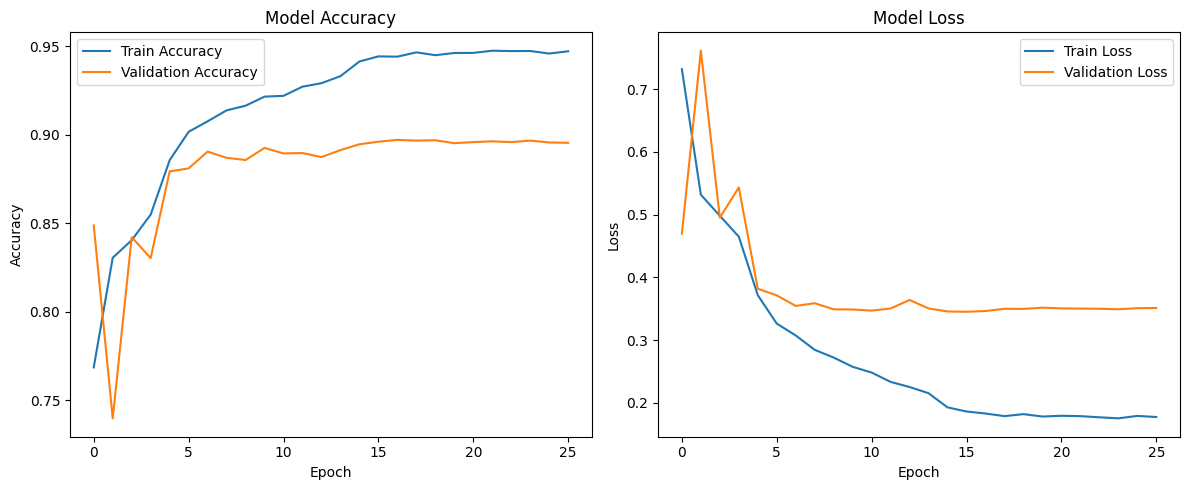

In [53]:

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

finetuned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = finetuned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_reducer]
)

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:

finetuned_model.save('finetuned_ecg_model2.h5')


In [ ]:
"""###Import Libraries"""
from tensorflow.keras.layers import (Conv2D, Add,Activation,
                                     Dropout,Dense,Flatten,Input,BatchNormalization,
                                      ReLU,MaxPooling2D,Concatenate,GlobalAveragePooling2D
                                     )
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, metrics, regularizers, callbacks
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import os

In [ ]:
"""#### Import Data"""

path = 'data path'

calssificatin_type = {"binary":1,"superclasses":5,"subclasses":23}
classification_name="subclasses"
no_of_classes=calssificatin_type[classification_name]

lead_type={"lead-I":1, "bipolar-limb":3 , "unipolar-limb":3, "limb-leads":6 , "precordial-leads":6,"all-lead":12}
lead_name= "all-lead"
no_of_leads=lead_type[lead_name]

x_train = np.load(path + 'x_train.npy',allow_pickle=True)
x_test  = np.load(path + 'x_test.npy',allow_pickle=True)
y_train = np.load(path + 'y_train.npy',allow_pickle=True)
y_test  = np.load(path + 'y_test.npy',allow_pickle=True)

# print(x_train.shape)
# print(x_test.shape)

x_train = x_train.transpose(0, 2, 1)            # transpose working correctly
x_test  = x_test.transpose(0, 2, 1)

# print(x_train.shape)
# print(x_test.shape)

x_train = x_train.reshape(19601, no_of_leads, 1000, 1)   # Add another channel
x_test  = x_test.reshape(2198, no_of_leads, 1000, 1)


print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')


from sklearn.preprocessing import MultiLabelBinarizer

if classification_name!="binary":
    mlb = MultiLabelBinarizer()
    mlb.fit(y_train)
    y_train = mlb.transform(y_train)

    mlb = MultiLabelBinarizer()
    mlb.fit(y_test)
    y_test = mlb.transform(y_test)
    print('Data proocessed')

In [ ]:
"""#### Model"""

input= Input(shape=(no_of_leads, 1000, 1))


conv1 = Conv2D(filters=32, kernel_size=(1,7),strides=(1, 1))(input)
batch1 = BatchNormalization()(conv1)
relu1 = ReLU()(batch1)

conv2 = Conv2D(filters=64, kernel_size=(1,5),strides=(1, 1))(relu1)
batch2 = BatchNormalization()(conv2)
relu2 = ReLU()(batch2)
drop2 = Dropout(rate=0.1)(relu2)
conv2 = Conv2D(filters=64, kernel_size=(1,5),strides=(1, 2))(drop2)

max1 = MaxPooling2D(pool_size=(1,9),strides=(1,2))(relu1)
conv_ = Conv2D(64, (1, 1))(max1)
conc1 = Add()([conv2, conv_])

batch3 = BatchNormalization()(conc1)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=64, kernel_size=(1,5),strides=(1, 1))(drop3)
batch3 = BatchNormalization()(conv3)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=64, kernel_size=(1,5),strides=(1, 2))(drop3)


max2 = MaxPooling2D(pool_size=(1,9),strides=(1,2))(conc1)
conc2 = Add()([conv3, max2])

batch3 = BatchNormalization()(conc2)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=128, kernel_size=(1,5),strides=(1, 1))(drop3)
batch3 = BatchNormalization()(conv3)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=128, kernel_size=(1,5),strides=(1, 2))(drop3)


max3 = MaxPooling2D(pool_size=(1,9),strides=(1,2))(conc2)
conv_ = Conv2D(128, (1, 1))(max3)
conc3 = Add()([conv3, conv_])

batch3 = BatchNormalization()(conc3)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=128, kernel_size=(1,5),strides=(1, 1))(drop3)
batch3 = BatchNormalization()(conv3)
relu3 = ReLU()(batch3)
drop3 = Dropout(rate=0.1)(relu3)
conv3 = Conv2D(filters=128, kernel_size=(1,5),strides=(1, 2))(drop3)


max4 = MaxPooling2D(pool_size=(1,9),strides=(1,2))(conc3)
conc4 = Add()([conv3, max4])
          

conv3 = Conv2D(filters=128, kernel_size=(no_of_leads, 1))(conc4)
X = BatchNormalization()(conv3)
X = ReLU()(X)
X = GlobalAveragePooling2D()(X)

X = Flatten()(X)
print(X.shape)

X = Dense(units=128, kernel_regularizer=tf.keras.regularizers.L2(0.005))(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(rate=0.1)(X)

X = Dense(units=64, kernel_regularizer=tf.keras.regularizers.L2(0.009))(X)
X = BatchNormalization()(X)
X = ReLU()(X)
X = Dropout(rate=0.15)(X)
print('Added 2 fully connected layers')

output = Dense(no_of_classes, activation='sigmoid')(X)
model = Model(inputs=input, outputs=output)

print(model.summary())


In [ ]:
"""#### Train Model"""
import tensorflow as tf 
early    = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reducelr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

callback = [early, reducelr]


model.compile(optimizer = optimizers.Adam(learning_rate=0.0005),
              loss = losses.BinaryCrossentropy(),
              metrics = [metrics.BinaryAccuracy(), metrics.AUC(curve='ROC', multi_label=True)])

history = model.fit(x_train, y_train, validation_split=0.12, epochs=100, batch_size=32, callbacks=callback)


In [ ]:
# """##### Save Model"""

save_path = 'save_path/'
model.save(save_path + "First_Paper.h5")



In [ ]:
"""Evaluate the model"""

from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc


def sklearn_metrics(y_true, y_pred):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

    # Compute area under precision-Recall curve
    auc_sum = 0
    for i in range(no_of_classes):
      precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:,i])
      auc_sum += auc(recall, precision)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten())* 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUPRC           : {:.2f}'.format((auc_sum / no_of_classes) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))



In [ ]:
from typing import Tuple
import numpy as np
import os

import numpy as np
import warnings
from sklearn.metrics import roc_auc_score, accuracy_score


def Metrics(y_true: np.ndarray, y_scores: np.ndarray) -> Tuple[float, float]:
    """Metrics for class-wise accuracy and mean accuracy.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted labels.

    Returns
    -------
    tuple[np.ndarray]
        Tuple of arrays containing class-wise accuracy and mean accuracy.

    """

    y_pred = y_scores >= 0.5
    acc = np.zeros(y_pred.shape[-1])

    for i in range(y_pred.shape[-1]):
        acc[i] = accuracy_score(y_true[:, i], y_pred[:, i])

    return acc.tolist(), np.mean(acc)


def AUC(y_true: np.ndarray, y_pred: np.ndarray, verbose: bool = False) -> float:
    """Computes the macro-averaged AUC score.

    Parameters
    ----------
    y_true : np.ndarray
        Ground truth labels.
    y_scores : np.ndarray
        Predicted probabilities.

    Returns
    -------
    float
        macro-average AUC score.

    """

    aucs = []
    assert (
        len(y_true.shape) == 2 and len(y_pred.shape) == 2
    ), "Predictions and labels must be 2D."
    for col in range(y_true.shape[1]):
        try:
            aucs.append(roc_auc_score(y_true[:, col], y_pred[:, col]))
        except ValueError as e:
            if verbose:
                print(
                    f"Value error encountered for label {col}, likely due to using mixup or "
                    f"lack of full label presence. Setting AUC to accuracy. "
                    f"Original error was: {str(e)}."
                )
            aucs.append((y_pred == y_true).sum() / len(y_pred))
    return aucs


In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

In [ ]:
print("Train")
sklearn_metrics(y_train, y_pred_train)
print("\nTest")
sklearn_metrics(y_test, y_pred_test)

In [ ]:
acc, mean_acc = Metrics(y_test, y_pred_test)
class_auc = AUC(y_test, y_pred_test)

print(f"class wise accuracy: {acc}")

print(f"class wise AUC : {class_auc}")